In [1]:
#!L
from IPython.display import Audio
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline

from scipy.io.wavfile import read
from scipy.signal import lfilter
from queue import Queue
import torch.optim as optim

import numpy as np
import librosa

import torch
import torch.nn as nn

from torch.utils.data import DataLoader

In [2]:
data = np.load("data/DK_Chaos.npy")

In [3]:
def amp_to_int(x, n=256):
    ### x.min must be negative
    step = (x.max() - x.min()) / n
    ans = np.zeros_like(x)
    for i, val in enumerate(np.arange(x.min(), x.max(), step)):
        for j in range(len(x)):
            if val <= x[j] < val + step:
                ans[j] = i
                
    return ans


def int_to_amp(x, x_true, n=256):
    ### x.min must be negative
    step = (x_true.max() - x_true.min()) / n
    ans = np.zeros_like(x, dtype=float)
    for j in range(len(x)):
        ans[j] = x_true.min() + x[j] * step
                
    return ans        
    

In [4]:
def one_hot(x, num_channels=256, device='cuda'):
    x_o = torch.FloatTensor(x.shape[0], num_channels, x.shape[1])
    x_o = x_o.to(device)
    x_o.zero_().scatter_(1, x.unsqueeze(1), 1)
    return x_o

In [5]:
int_data = amp_to_int(data)
train = int_data[:-20000]
test = int_data[-20000:]

In [6]:
#!L
class CausalConv1d(nn.Conv1d):
    def __init__(self, *args, **kwargs):
        super(CausalConv1d, self).__init__(*args, **kwargs)
        self.padding = ((self.kernel_size[0] - 1) * self.dilation[0],)

    def forward(self, x):
        x = super(CausalConv1d, self).forward(x)
        return x[:, :, :-self.padding[0]]

    



class WaveNet(nn.Module):
    """WaveNet architecture with local conditioning

    https://arxiv.org/pdf/1609.03499.pdf - original paper
    https://arxiv.org/pdf/1702.07825.pdf - appending A for more details
    
    But given implementation has following differences:
    1. tanh is not applied to input embedding
    2. vector is scaled (multiplied 0.5 ** 0.5) between blocks
    3. GRU is used for processing mel spectrogram
    4. GRU output is nearest neighbour apsampled hop_size times
    5. each block has own conditioning projection

    Args:
        num_channels       (int): size of modelled categorical distribution
        residual_channels  (int): hidden vector size
        gate_channels      (int): gate block dimension
        skip_channels      (int): skip-vector size
        pre_channels       (int): dimension before the last layer
        dilation_cycles    (int): number of dilation cycles
        dilation_depth     (int): blocks number in dilation cycle (e.g. if set 10, max dilation = 2^(10-1))
        condition_channels (int): number of mel filters
        hop_size           (int): STFT hop size
    """

    def __init__(self,
                 num_channels,
                 residual_channels,
                 gate_channels,
                 skip_channels,
                 pre_channels,
                 dilation_cycles,
                 dilation_depth,
                 condition_channels,
                 hop_size):
        super(WaveNet, self).__init__()
        
        self.kernel_size = 2
        self.dilations = np.array([
            2 ** (i % dilation_depth) 
            for i in range(dilation_cycles * dilation_depth)
        ])
        
        self.num_channels = num_channels
        self.residual_channels = residual_channels
        self.gate_channels = gate_channels
        self.skip_channels = skip_channels
        self.pre_channels = pre_channels
        self.hop_size = hop_size
        
        
        self.conv_input = nn.Conv1d(
            in_channels=num_channels,
            out_channels=residual_channels,
            kernel_size=1)

        self.blocks_conv_filter = nn.ModuleList([
            CausalConv1d(
                in_channels=residual_channels,
                out_channels=gate_channels,
                kernel_size=2,
                dilation=d
            ) for d in self.dilations])

        self.blocks_conv_gate = nn.ModuleList([
            CausalConv1d(
                in_channels=residual_channels,
                out_channels=gate_channels,
                kernel_size=2,
                dilation=d
            ) for d in self.dilations])
        
        self.blocks_conv_residual = nn.ModuleList([
            nn.Conv1d(
                in_channels=gate_channels,
                out_channels=residual_channels,
                kernel_size=1
            ) for _ in range(len(self.dilations) - 1)])
        
        self.blocks_conv_skip = nn.ModuleList([
            nn.Conv1d(
                in_channels=gate_channels,
                out_channels=skip_channels,
                kernel_size=1
            ) for _ in range(len(self.dilations))])
        
        
        self.conv_out_1 = nn.Conv1d(
            in_channels=skip_channels,
            out_channels=pre_channels,
            kernel_size=1)
        self.conv_out_2 = nn.Conv1d(
            in_channels=pre_channels,
            out_channels=num_channels,
            kernel_size=1)

    def forward(self, x):
        """
        Args:
            x (FloatTensor): continuous audio signal [B x K x T]
            c (FloatTensor): local condition features [B x L x C],
                where L = T // 300

        Returns:
            FloatTensor: output [B x out_channels x T]
        """
        
        x = self.conv_input(x) # equal to x = torch.matmul(x.transpose(1, 2), model.conv_input.weight.squeeze().transpose(0, 1)) + model.conv_input.bias and transpose(1, 2)
        

        x_acc = 0
        for b in range(len(self.dilations)):
            x_filter = self.blocks_conv_filter[b](x)
            x_gate = self.blocks_conv_gate[b](x)


            x_hidden = torch.tanh(x_filter) * torch.sigmoid(x_gate)

            x_skip = self.blocks_conv_skip[b](x_hidden)
            x_acc = x_acc + x_skip

            if b < len(self.dilations) - 1:
                x_residual = self.blocks_conv_residual[b](x_hidden)
                x = x + x_residual

            x = x * 0.5 ** 0.5
            

        x = self.conv_out_1(torch.relu(x_acc))
        x = self.conv_out_2(torch.relu(x))

        return x

In [7]:
#!L
model = WaveNet(
    num_channels=256,
    residual_channels=64,
    gate_channels=64,
    skip_channels=128,
    pre_channels=256,
    dilation_cycles=3,
    dilation_depth=8,
    condition_channels=80,
    hop_size=300)
model.to('cuda')

WaveNet(
  (conv_input): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
  (blocks_conv_filter): ModuleList(
    (0): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (2): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(4,), dilation=(4,))
    (3): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(8,), dilation=(8,))
    (4): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(16,), dilation=(16,))
    (5): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(32,), dilation=(32,))
    (6): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(64,), dilation=(64,))
    (7): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(128,), dilation=(128,))
    (8): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(1,))
    (9): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (10): Ca

In [7]:
from IPython.display import clear_output

In [8]:
model.load_state_dict(torch.load("WaveNetModel"))

NameError: name 'model' is not defined

In [30]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Floating
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [31]:

lstm_train = data[:-20000]
lstm_test =  data[-20000:]

mean = lstm_train.mean()
std = lstm_train.std()
#sigmastest = np.abs(test - mean)
train_norm = (lstm_train - mean)/std
test_norm = (lstm_test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [32]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_norm, train_window)
test_inout_seq = create_inout_sequences(test_norm, train_window)

In [33]:
train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=False, drop_last=True)

In [34]:
model_lstm = LSTMModel(input_size=1, hidden_layer_size=100, num_layers=2, output_size=1, dropout=0.2)
model_lstm = model_lstm.to('cuda')

In [ ]:
def run_epoch(model, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        y = y.view(-1).to('cuda')

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)


    return epoch_loss

In [ ]:
from IPython.display import clear_output

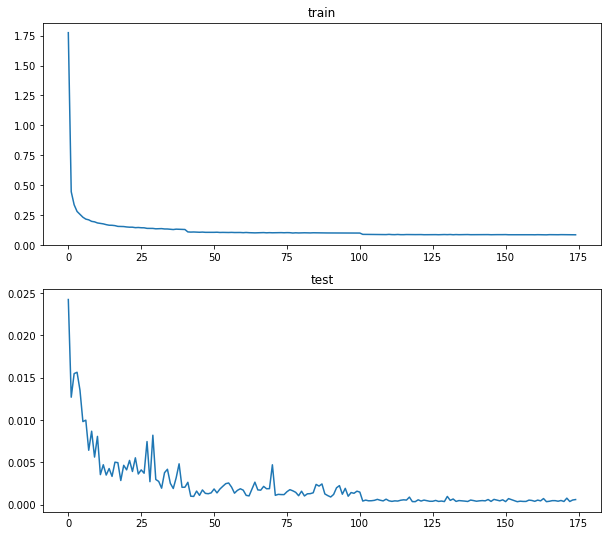

Epoch[175/175] | loss train:0.084393, test:0.000613


In [18]:
# define optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-9)
lr = 0.001
epochs = 175

losses_train = []
losses_test = []
# begin training
for epoch in range(epochs): 
    if epoch > 40:
        lr = 0.0005
    if epoch > 100:
        lr = 0.0001
    optimizer = optim.Adam(model_lstm.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-9)    
    loss_train = run_epoch(model_lstm, train_dataloader, is_training=True)
    loss_val = run_epoch(model_lstm, test_dataloader)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, epochs, loss_train, loss_val))

In [19]:
#torch.save(model_lstm.state_dict(), "./LSTMChaosLarge")

In [35]:
model_lstm.load_state_dict(torch.load('LSTMChaosLarge'))

<All keys matched successfully>

In [49]:
def GetRmse(model, train_dataloader, val_dataloader, test, std, mean):
    model.eval()

    rmse = []
    
    lstm_predicts = []
    for k in tqdm(range(1, 20)):
        test_right_part = (len(lstm_test)- 20)%64
        predicted_val = np.array([])
        for idx, (x, y) in enumerate(val_dataloader):
            x = torch.reshape(x, (64, 20, 1)).to('cuda')
            cur_x = x
            for _ in range(k):
                out = model(cur_x.to('cuda'))
                cur_x = torch.hstack((cur_x[:, 1:], torch.reshape(out, (64, 1, 1))))
            predicted_val = np.concatenate((predicted_val, cur_x[:, -1, 0].cpu().detach().numpy()))
            
        lstm_predicts.append(np.array(predicted_val)*std+mean)
        if k == 1:
            r = (((np.array(predicted_val)*std+mean - np.array(lstm_test[20:-test_right_part]))**2).mean())**0.5
        else:
            r = (((np.array(predicted_val[:-k+1])*std+mean - np.array(lstm_test[20+k-1:-test_right_part]))**2).mean())**0.5
        rmse.append(r)
    return rmse, lstm_predicts

In [50]:
rmse_chaos, lstm_predicts = GetRmse(model_lstm, train_dataloader, test_dataloader, test, std, mean)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]


In [10]:
from torch.distributions.categorical import Categorical

In [17]:
def initialize_buffer(model, x):
    model.eval()
    model.to('cpu')
    with torch.no_grad():

        x = one_hot(torch.LongTensor(x).unsqueeze(0), 256, device='cpu')

        #x = model.conv_input(x)
#         print(x.size())
#         assert x.size() == torch.Size([1, 256, 1])

        receptive_field = (model.kernel_size - 1) * model.dilations.sum() + 1
        

        #c = F.pad(c, (receptive_field, 0), "replicate")

        buffer = torch.zeros((40, 64, 520))
        dilations = model.dilations
        
        fill_zero = torch.zeros((1, 256, 1))
        fill_zero[:, 127, :] = 1

        fill_buffer = model.conv_input(fill_zero)
        for i in range(40):
            for j in range(520):
                buffer[i, :, j] = fill_buffer[0, :, 0]

        x_new = x

        res = []
        for i in tqdm(range(x.shape[-1])): #
            next_iter = torch.zeros((40, 64, 1)) # to replace queue

            buffer = torch.cat((buffer, next_iter), 2)

            

            #assert x_new.size() == torch.Size([1, 64, 1])

           
            x_new = model.conv_input(x[:, :, i].unsqueeze(2))                       
            buffer[0, :, -1] = x_new.squeeze()                     
            

            x_acc = 0


            for b in range(len(dilations)):

                input = torch.cat((buffer[b, : ,-dilations[b]-1].unsqueeze(1), buffer[b, : ,-1].unsqueeze(1)), 1)

                x_filter = (input.unsqueeze(0) * model.blocks_conv_filter[b].weight).sum(axis=2).sum(axis=1) + model.blocks_conv_filter[b].bias

                x_filter = x_filter.unsqueeze(0).unsqueeze(2)


                x_gate = (input.unsqueeze(0) * model.blocks_conv_gate[b].weight).sum(axis=2).sum(axis=1) + model.blocks_conv_gate[b].bias

                x_gate = x_gate.unsqueeze(0).unsqueeze(2)


                x_hidden = torch.tanh(x_filter) * torch.sigmoid(x_gate)

                x_skip = model.blocks_conv_skip[b](x_hidden)

                x_acc = x_acc + x_skip

                if b < len(model.dilations) - 1:
                    x_residual = model.blocks_conv_residual[b](x_hidden)

                    buffer[b+1, :, -1] = (buffer[b, : ,-1].unsqueeze(0).unsqueeze(2) + x_residual).squeeze()
                    buffer[b+1, :, -1] = buffer[b+1, :, -1] * 0.5 ** 0.5


            buffer = buffer[:, :, 1:]



    return buffer

In [61]:
def infer(model, init_buffer, x, l, k=20, mode='sampling'):
    model.eval()
    model.to('cpu')
    with torch.no_grad():

        x = one_hot(torch.LongTensor(x).unsqueeze(0), 256, device='cpu')

        #x = model.conv_input(x)
#         print(x.size())
#         assert x.size() == torch.Size([1, 256, 1])

        receptive_field = (model.kernel_size - 1) * model.dilations.sum() + 1
        

        #c = F.pad(c, (receptive_field, 0), "replicate")

        buffer = init_buffer
        dilations = model.dilations
        

        x_new = x

        res = []
        for i in tqdm(range(l)): #
            #next_iter = torch.zeros((40, 64, 1)) # to replace queue
            cur_buffer = buffer

            #buffer = torch.cat((buffer, next_iter), 2)

           
            #x_new = model.conv_input(x[:, :, i].unsqueeze(2))
            cur_x_new = x[:, :, i].unsqueeze(2)
            
            for step in range(k):
                next_iter = torch.zeros((40, 64, 1)) # to replace queue

                cur_buffer = torch.cat((cur_buffer, next_iter), 2)


                cur_x_new = model.conv_input(cur_x_new)
                cur_buffer[0, :, -1] = cur_x_new.squeeze() #new_x

                x_acc = 0


                for b in range(len(dilations)):

                    input = torch.cat((cur_buffer[b, : ,-dilations[b]-1].unsqueeze(1), cur_buffer[b, : ,-1].unsqueeze(1)), 1)

                    x_filter = (input.unsqueeze(0) * model.blocks_conv_filter[b].weight).sum(axis=2).sum(axis=1) + model.blocks_conv_filter[b].bias

                    x_filter = x_filter.unsqueeze(0).unsqueeze(2)


                    x_gate = (input.unsqueeze(0) * model.blocks_conv_gate[b].weight).sum(axis=2).sum(axis=1) + model.blocks_conv_gate[b].bias

                    x_gate = x_gate.unsqueeze(0).unsqueeze(2)


                    x_hidden = torch.tanh(x_filter) * torch.sigmoid(x_gate)

                    x_skip = model.blocks_conv_skip[b](x_hidden)

                    x_acc = x_acc + x_skip

                    if b < len(model.dilations) - 1:
                        x_residual = model.blocks_conv_residual[b](x_hidden)

                        cur_buffer[b+1, :, -1] = (cur_buffer[b, : ,-1].unsqueeze(0).unsqueeze(2) + x_residual).squeeze()
                        cur_buffer[b+1, :, -1] = cur_buffer[b+1, :, -1] * 0.5 ** 0.5


                cur_buffer = cur_buffer[:, :, 1:]

                cur_x_new = model.conv_out_1(torch.relu(x_acc))
                cur_x_new = model.conv_out_2(torch.relu(cur_x_new))
                
                if step == 0:
                    buffer = cur_buffer

                action = 0
                if mode == "sampling":

                    probs = cur_x_new[0, :, 0]
                    probs = nn.Softmax()(probs)
                    m = Categorical(probs)
                    action = m.sample()
                    
                else:
                    action = np.argmax(cur_x_new[0, :, 0])
                
                if step == k - 1:
                    res.append(action)

                ans = torch.zeros((1, 256, 1))
                ans[0, action, 0] = 1
                cur_x_new = ans


    res = np.array(res)

    return res

In [18]:
init_buffer = initialize_buffer(model, train[-1000:])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.20it/s]


In [20]:
predict = infer(model, init_buffer, test, len(test))

  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]C:\Users\gromo\AppData\Local\Temp\ipykernel_2256\1273566562.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.Softmax()(probs)
100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:47<00:00, 69.64it/s]


In [21]:
val_predict = int_to_amp(predict, data, n=256)

In [22]:
val_predict

(20000,)

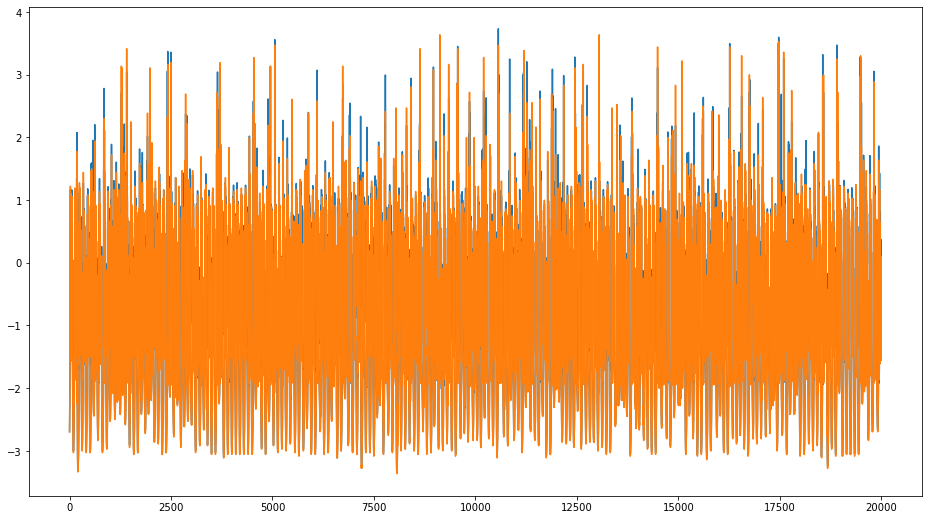

In [25]:
plt.figure(figsize = (16, 9))

plt.plot(data[-19999:])
plt.plot(val_predict[:-1])

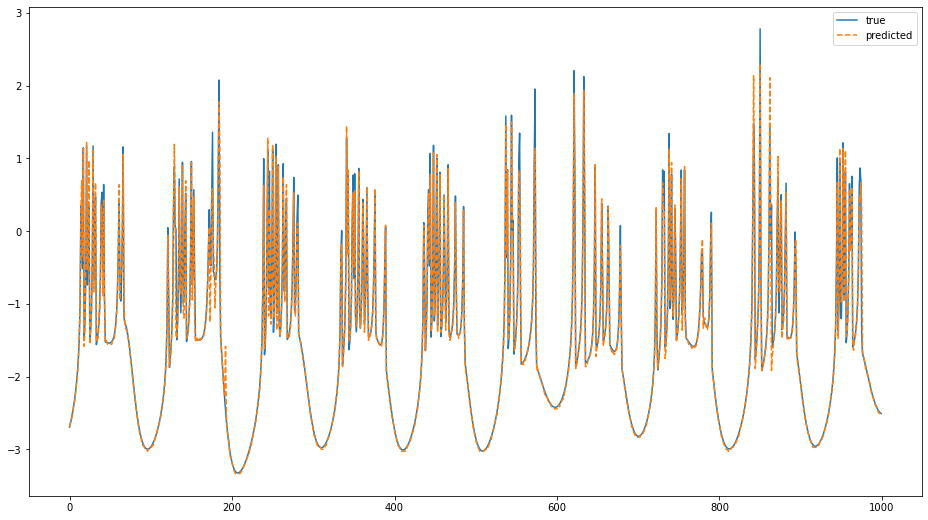

In [26]:
plt.figure(figsize = (16, 9))
plt.plot(data[-19999:-19999 + 1000], label='true')
plt.plot(val_predict[:1000],  linestyle = '--', label='predicted')
plt.legend()

In [27]:
(((val_predict[:-1] - data[-19999:])**2).mean())**0.5

0.14173222040213376

In [52]:
rmse_chaos[0]

0.011946420951449689

In [46]:
argmax_predict = infer(model, init_buffer, test, len(test), mode='argmax')

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:42<00:00, 70.72it/s]


In [49]:
argmax_val_predict = int_to_amp(argmax_predict, data, n=256)

In [50]:
(((argmax_val_predict[:-1] - data[-19999:])**2).mean())**0.5

0.12045402695008177

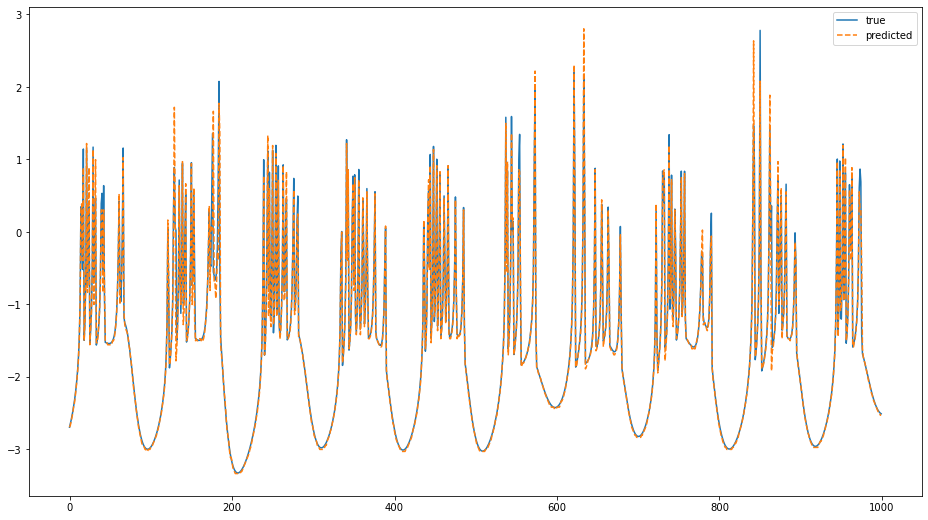

In [53]:
plt.figure(figsize = (16, 9))
plt.plot(data[-19999:-19999 + 1000], label='true')
plt.plot(argmax_val_predict[:1000],  linestyle = '--', label='predicted')
plt.legend()

In [68]:
test_2_step_predict = infer(model, init_buffer, test, len(test), k=2, mode='argmax')

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [09:28<00:00, 35.20it/s]


In [77]:
argmax_val_predict_2_step = int_to_amp(argmax_predict, data, n=256)

In [81]:
(((argmax_val_predict_2_step[:-2] - data[-19998:])**2).mean())**0.5

0.7650272680189186

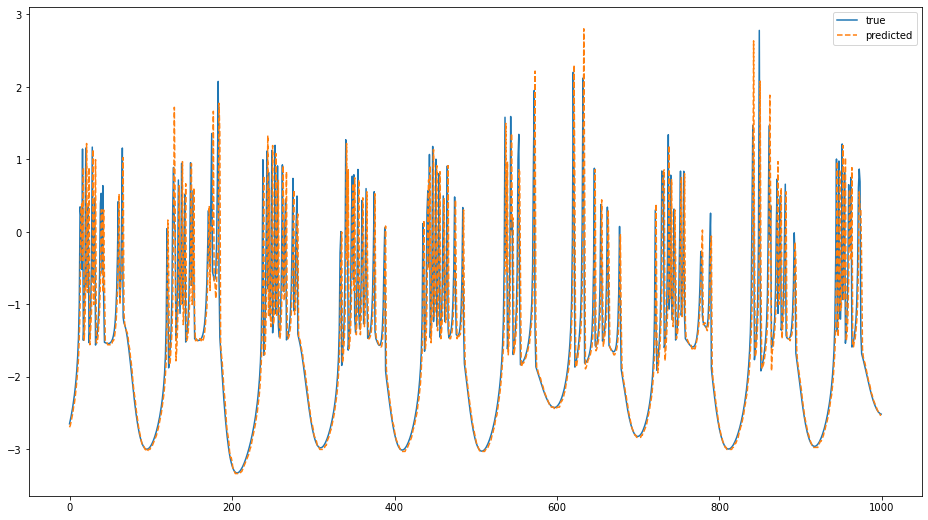

In [83]:
plt.figure(figsize = (16, 9))
plt.plot(data[-19998:-19998 + 1000], label='true')
plt.plot(argmax_val_predict_2_step[:1000],  linestyle = '--', label='predicted')
plt.legend()

In [22]:
predicts = []
for i in range(1, 20):
    predict = np.load("pr" + str(i) + ".npy")
    predicts.append(predict)

In [10]:
def CalcRMSE(x, y):
    return (((x - y)**2).mean())**0.5

In [23]:
(((int_to_amp(predicts[0], data, n=256)[:-1] - data[-19999:])**2).mean())**0.5

0.12045402695008177

In [25]:
wavenet_rmses = []
for i in tqdm(range(19)):
    wavenet_rmses.append(CalcRMSE(int_to_amp(predicts[i], data, n=256)[:-1-i], data[-19999 + i:]))

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:12<00:00,  1.48it/s]


In [27]:
import matplotlib.ticker as ticker

Text(0.5, 0, 'prediction step')

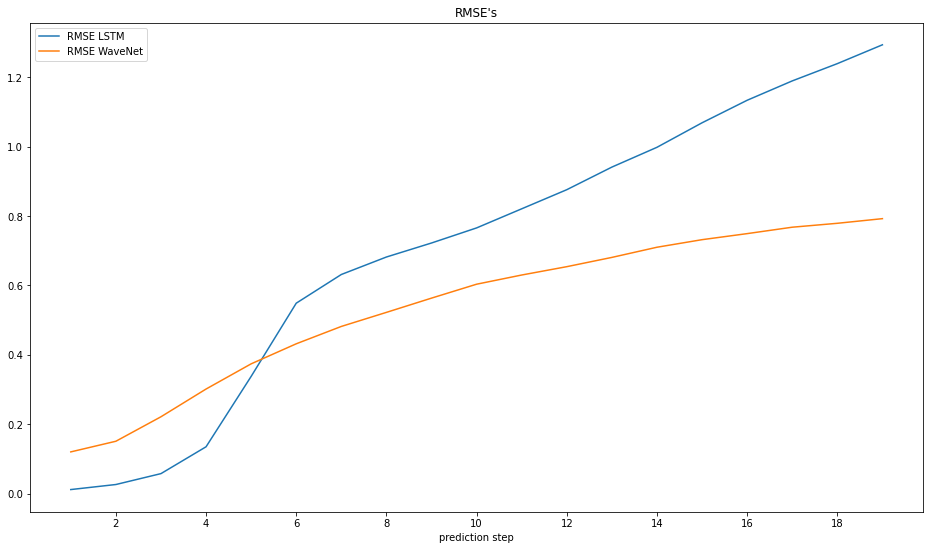

In [38]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(list(range(1, 20)), rmse_chaos, label="RMSE LSTM")
ax.plot(list(range(1, 20)), wavenet_rmses, label="RMSE WaveNet")
ax.legend()
ax.set_title("RMSE's")
ax.set_xlabel("prediction step")

In [54]:
def Plt(k):
    k = 5
    fig = plt.figure(figsize = (16, 16))
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_1.plot(data[-20000 + k:-20000 + k + 1000], label='true')
    ax_1.plot(int_to_amp(predicts[k-1], data, n=256)[:1000],  linestyle = '--', label='predicted')
    ax_1.legend()
    ax_1.set_title('WaveNet')
    
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_2.plot(lstm_test[20+k-1: 20+k-1 + 1000], label='true')
    ax_2.plot(lstm_predicts[k-1][:1000],  linestyle = '--', label='predicted')
    ax_2.legend()
    ax_2.set_title('LSTM')
    plt.show()
    

### Предсказание на 5 шагов

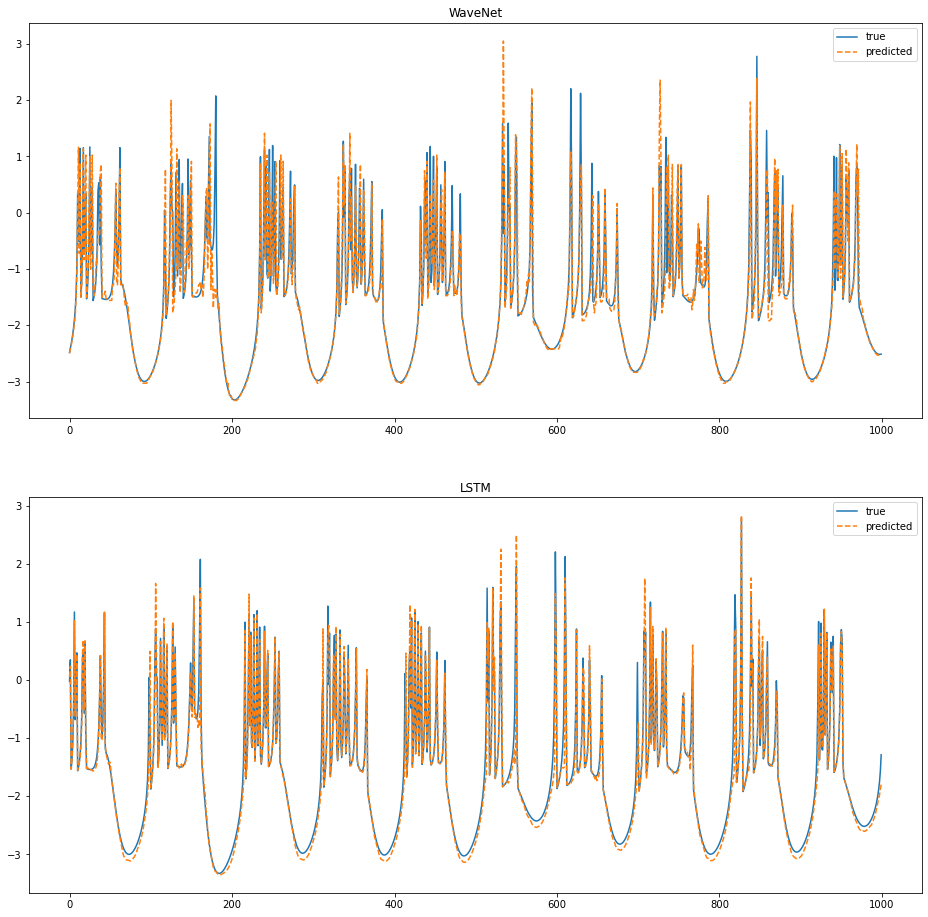

In [55]:
Plt(5)

### Предсказание на 10 шагов

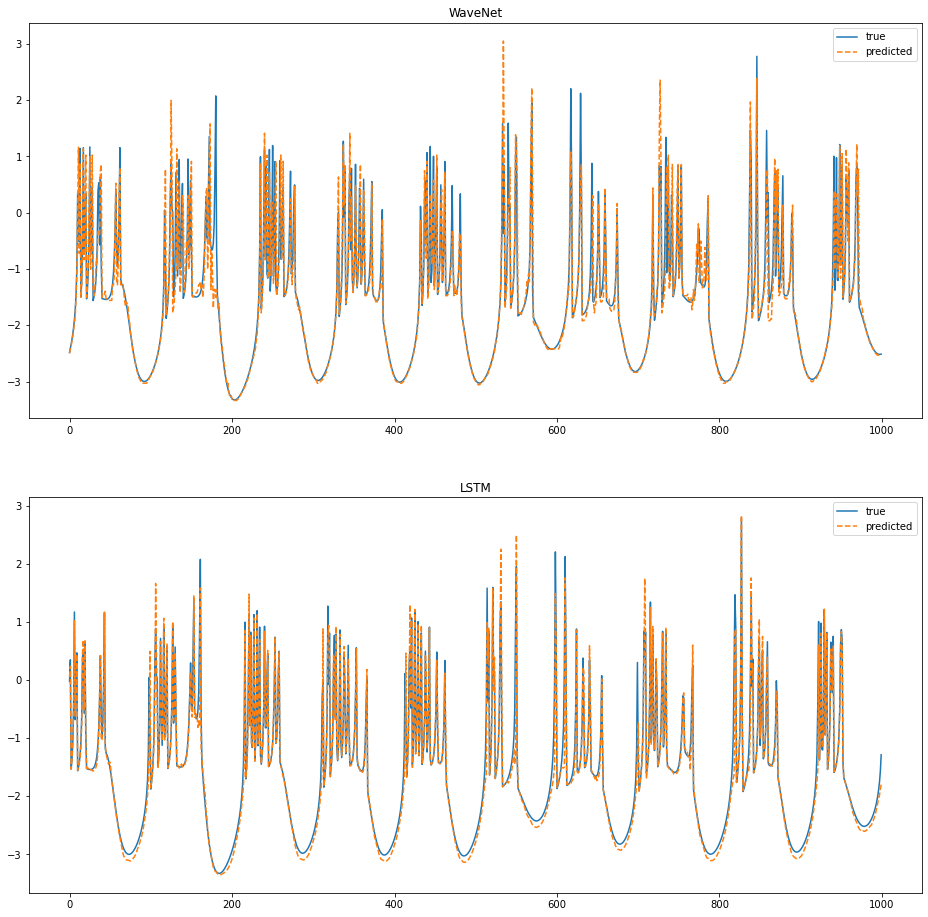

In [56]:
Plt(10)

### Предсказание на 15 шагов

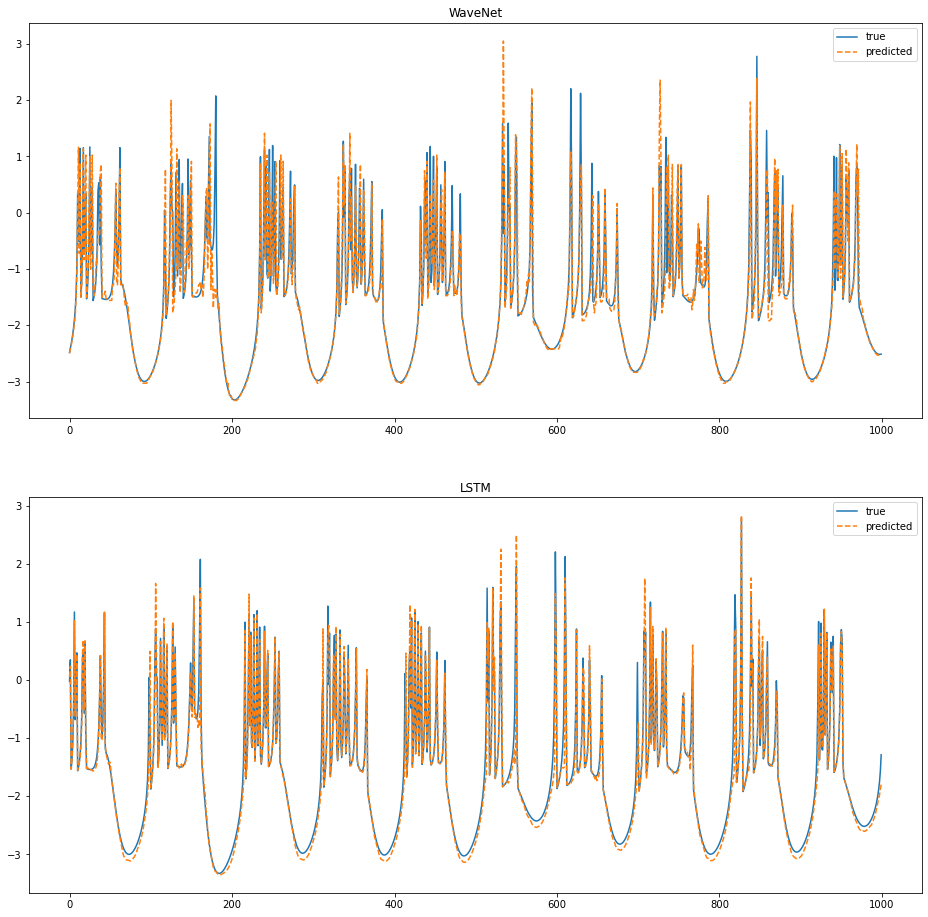

In [57]:
Plt(15)

### Предсказание на 19 шагов

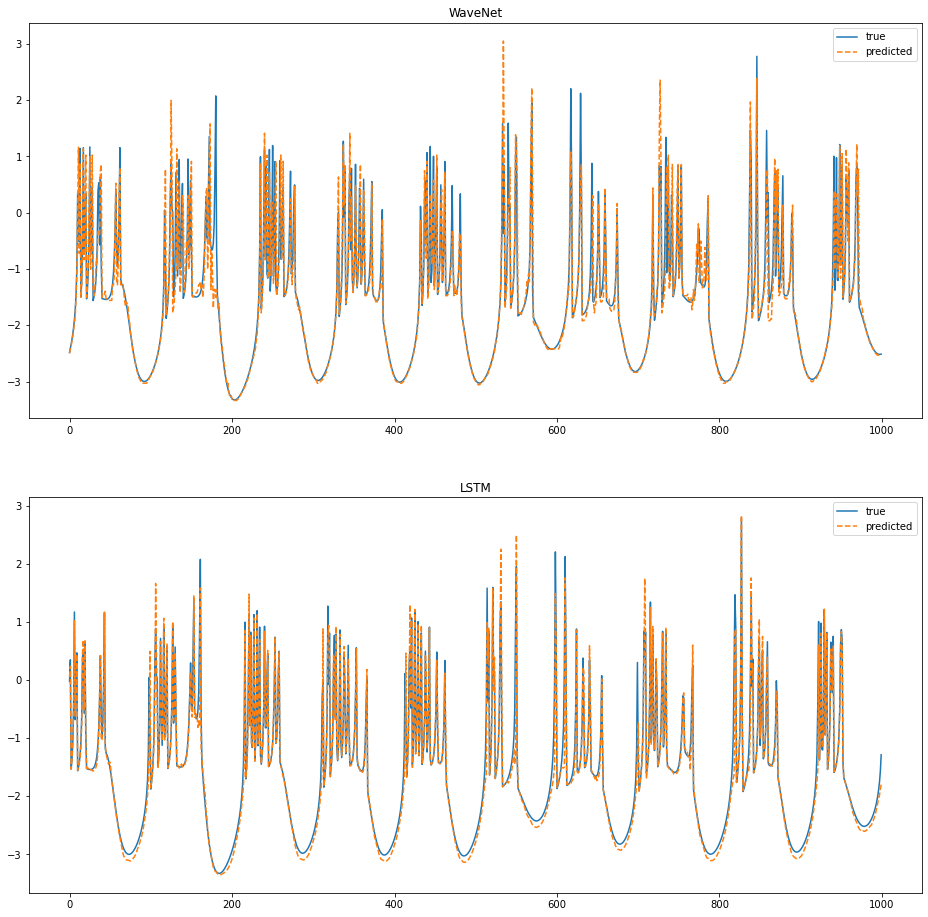

In [58]:
Plt(19)

In [85]:
predicts = []
for k in range(3, 11):
    print("Current step:", k)
    predicts.append(infer(model, init_buffer, test, len(test), k=k, mode='argmax'))

Current step: 3


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [13:35<00:00, 24.51it/s]


Current step: 4


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [15:45<00:00, 21.15it/s]


Current step: 5


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [19:55<00:00, 16.73it/s]


Current step: 6


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [24:03<00:00, 13.86it/s]


Current step: 7


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [28:08<00:00, 11.84it/s]


Current step: 8


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [31:52<00:00, 10.46it/s]


Current step: 9


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [36:31<00:00,  9.13it/s]


Current step: 10


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [42:53<00:00,  7.77it/s]


In [86]:
predicts_part_2 = []
for k in range(11, 20):
    print("Current step:", k)
    predicts.append(infer(model, init_buffer, test, len(test), k=k, mode='argmax'))

Current step: 11


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [53:58<00:00,  6.18it/s]


Current step: 12


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [58:44<00:00,  5.67it/s]


Current step: 13


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [1:01:11<00:00,  5.45it/s]


Current step: 14


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [1:23:11<00:00,  4.01it/s]


Current step: 15


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [1:18:18<00:00,  4.26it/s]


Current step: 16


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [1:20:58<00:00,  4.12it/s]


Current step: 17


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [1:11:47<00:00,  4.64it/s]


Current step: 18


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [1:12:12<00:00,  4.62it/s]


Current step: 19


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [1:15:29<00:00,  4.42it/s]


In [89]:
for i in range(len(predicts_part_2)):
    np.save("pr" + str(i + 11), predicts_part_2[i])

In [92]:
len(predicts)

17

In [93]:
for i in range(len(predicts)):
    np.save("pr" + str(i + 3), predicts[i])

In [94]:
np.save("pr" + str(1), argmax_predict)

In [95]:
np.save("pr" + str(2), test_2_step_predict)

### Draft asserts part

In [69]:
def test_infer(model, init_buffer, x, l):
    model.eval()
    model.to('cpu')
    with torch.no_grad():

        x = one_hot(torch.LongTensor(x).unsqueeze(0).unsqueeze(0), 256, device='cpu')

        #x = model.conv_input(x)

        assert x.size() == torch.Size([1, 256, 1])

        receptive_field = (model.kernel_size - 1) * model.dilations.sum() + 1
        

        #c = F.pad(c, (receptive_field, 0), "replicate")

        buffer = init_buffer
        dilations = model.dilations

        
        x_new = x

        res = []
        for i in tqdm(range(l)): #
            next_iter = torch.zeros((40, 64, 1)) # to replace queue

            buffer = torch.cat((buffer, next_iter), 2)

            x_new = model.conv_input(x_new)

            #assert x_new.size() == torch.Size([1, 64, 1])


            buffer[0, :, -1] = x_new.squeeze() #new_x

            x_acc = 0


            for b in range(len(dilations)):

                input = torch.cat((buffer[b, : ,-dilations[b]-1].unsqueeze(1), buffer[b, : ,-1].unsqueeze(1)), 1)

                x_filter = (input.unsqueeze(0) * model.blocks_conv_filter[b].weight).sum(axis=2).sum(axis=1) + model.blocks_conv_filter[b].bias

                x_filter = x_filter.unsqueeze(0).unsqueeze(2)


                x_gate = (input.unsqueeze(0) * model.blocks_conv_gate[b].weight).sum(axis=2).sum(axis=1) + model.blocks_conv_gate[b].bias

                x_gate = x_gate.unsqueeze(0).unsqueeze(2)


                x_hidden = torch.tanh(x_filter) * torch.sigmoid(x_gate)

                x_skip = model.blocks_conv_skip[b](x_hidden)

                x_acc = x_acc + x_skip

                if b < len(model.dilations) - 1:
                    x_residual = model.blocks_conv_residual[b](x_hidden)

                    buffer[b+1, :, -1] = (buffer[b, : ,-1].unsqueeze(0).unsqueeze(2) + x_residual).squeeze()
                    buffer[b+1, :, -1] = buffer[b+1, :, -1] * 0.5 ** 0.5


            buffer = buffer[:, :, 1:]

            x_new = model.conv_out_1(torch.relu(x_acc))
            x_new = model.conv_out_2(torch.relu(x_new))

            
            action = np.argmax(x_new[0, :, 0])


            res.append(action)

            ans = torch.zeros((1, 256, 1))
            ans[0, action, 0] = 1
            x_new = ans


    res = np.array(res)

    return res

In [72]:
assert_2_step_correct = test_infer(model, init_buffer, np.array(test[0]), 10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 70.06it/s]


In [73]:
assert assert_2_step_correct[1] == test_2_step_predict[0]